# Quick start

...

In [1]:
# bash generate_data.sh

In [77]:
import os
import gzip

import numpy as np
import scipy.stats

import skimage.transform
from keras import models, layers, activations, optimizers, regularizers
from keras.utils import to_categorical, plot_model
from keras.models import load_model

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pymc3 # this will be removed
import pydot # optional

In [188]:
%run -i ImaGene.py

In [79]:
myfile = ImaFile(simulations_folder='/home/mfumagal/Data/ImaGene/Simulations1.Epoch2', nr_samples=128, model_name='Marth-2epoch-CEU')

In [80]:
mypop = myfile.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=25)

In [81]:
mypop.summary()

An object of 10025 images
Rows: min 128, max 128, mean 128.000000, std 0.000000
Columns: min 271, max 643, mean 427.979651, std 61.344069


0

Text(0, 0.5, 'Allele frequency')

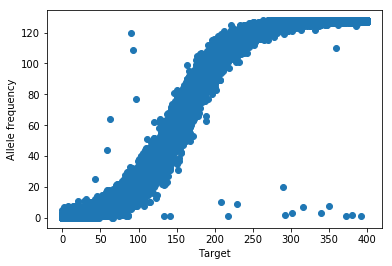

In [82]:
freqs = calculate_allele_frequency(mypop, 0.5)
plt.scatter(mypop.targets, freqs, marker='o')
plt.xlabel('Target')
plt.ylabel('Allele frequency')

In [83]:
mypop.majorminor()
mypop.sort('rows_freq')
mypop.sort('cols_freq')
mypop.resize((128, 128))
mypop.convert()

Converting to numpy array.
Converting to float32.
Converting to [0,1].
Flipping values.
A numpy array with dimensions (10025, 128, 128, 1) and 10025 targets and 401 classes.


0

In [84]:
rnd_idx = get_index_random(mypop)
mypop.subset(rnd_idx)

0

In [85]:
mypop.data.shape

(10025, 128, 128, 1)

0


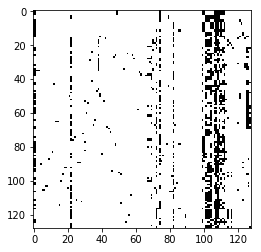

100


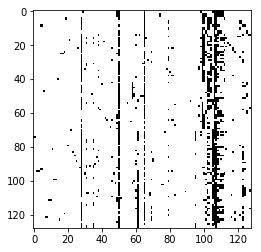

200


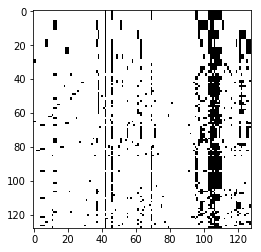

300


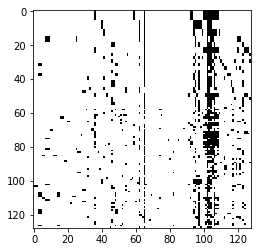

400


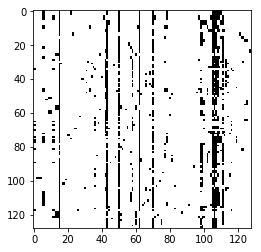

In [86]:
for sel in [0,100,200,300,400]:
    ind=np.where(mypop.targets == sel)[0][1]
    print(sel)
    mypop.plot(ind)

In [87]:
#mypop.set_classes(nr_classes=4)
#print(mypop.classes)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195.
 196. 

In [88]:
mypop.set_targets(wiggle=0, sd=0)
mypop.targets

array([346,  66, 144, ..., 386, 365, 192])

In [89]:
myclasses = np.array([0,100])
classes_idx = get_index_classes(mypop.targets, myclasses)
classes_idx

array([1995, 2574, 2878, 2934, 3587, 3691, 3896, 4506, 4529, 5049, 5082,
       5620, 5629, 5822, 5896, 6520, 6716, 6781, 7241, 8539, 8557, 8676,
       9151, 9530, 9842,   17, 1140, 1452, 1633, 2402, 2763, 3251, 4242,
       5204, 5872, 6122, 6238, 6266, 6333, 6340, 6599, 6851, 6913, 6932,
       7445, 7861, 8274, 8693, 8831, 9290])

In [90]:
mypop.subset(classes_idx)
mypop.data.shape

(50, 128, 128, 1)

In [91]:
rnd_idx = get_index_random(mypop)
mypop.subset(rnd_idx)

0

In [26]:
# mypop.targets = to_categorical(mypop.targets) # for multiclassification

In [93]:
mypop.classes = myclasses
del myclasses

In [95]:
mypop.set_targets(wiggle=0, sd=0)
mypop.targets

array([0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1.],
      dtype=float32)

In [189]:
mynet = ImaNet(mypop)

In [190]:
model = models.Sequential([
                        layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid', input_shape=mynet.input_shape),
                        layers.MaxPooling2D(pool_size=(2,2)),
                        layers.Dropout(rate=0.5),
                        layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'),
                        layers.MaxPooling2D(pool_size=(2,2)),
                        layers.Dropout(rate=0.5),
                        layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'),
                        layers.MaxPooling2D(pool_size=(2,2)),
                        layers.Dropout(rate=0.5),
                        layers.Flatten(),
                        layers.Dense(units=128, activation='relu'),
                        layers.Dense(units=mynet.output_shape-1, activation='sigmoid')])
                        #layers.Dense(units=mynet.output_shape, activation='softmax')])

In [191]:
model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [192]:
mynet.input_shape

(128, 128, 1)

In [193]:
mynet.net = model
mynet.plot_net()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 28, 28, 32)        9248      
__________

0

In [103]:
#model.fit(mypop.data, mypop.targets, batch_size=32, epochs=20, verbose=1, validation_split=0.20)

Train on 40 samples, validate on 10 samples
Epoch 1/20
40/40 [==============================] - 0s 9ms/step - loss: 0.6839 - acc: 0.5750 - val_loss: 0.6998 - val_acc: 0.3000
Epoch 2/20
40/40 [==============================] - 0s 4ms/step - loss: 0.6894 - acc: 0.4750 - val_loss: 0.6960 - val_acc: 0.3000
Epoch 3/20
40/40 [==============================] - 0s 4ms/step - loss: 0.6991 - acc: 0.4750 - val_loss: 0.6947 - val_acc: 0.3000
Epoch 4/20
40/40 [==============================] - 0s 4ms/step - loss: 0.7114 - acc: 0.4250 - val_loss: 0.6998 - val_acc: 0.3000
Epoch 5/20
40/40 [==============================] - 0s 4ms/step - loss: 0.6974 - acc: 0.5500 - val_loss: 0.6947 - val_acc: 0.3000
Epoch 6/20
40/40 [==============================] - 0s 4ms/step - loss: 0.6844 - acc: 0.6000 - val_loss: 0.6989 - val_acc: 0.3000
Epoch 7/20
40/40 [==============================] - 0s 4ms/step - loss: 0.6721 - acc: 0.5750 - val_loss: 0.6995 - val_acc: 0.3000
Epoch 8/20
40/40 [============================

In [194]:
mynet.train(epochs=20, batch_size=32)

Train on 32 samples, validate on 8 samples
Epoch 1/20
32/32 [==============================] - 1s 25ms/step - loss: 0.6821 - acc: 0.5312 - val_loss: 1.9130 - val_acc: 0.6250
Epoch 2/20
32/32 [==============================] - 0s 4ms/step - loss: 7.5554 - acc: 0.5312 - val_loss: 1.9130 - val_acc: 0.6250
Epoch 3/20
32/32 [==============================] - 0s 4ms/step - loss: 7.5554 - acc: 0.5312 - val_loss: 1.9130 - val_acc: 0.6250
Epoch 4/20
32/32 [==============================] - 0s 4ms/step - loss: 7.5554 - acc: 0.5312 - val_loss: 1.9130 - val_acc: 0.6250
Epoch 5/20
32/32 [==============================] - 0s 4ms/step - loss: 7.5554 - acc: 0.5312 - val_loss: 1.9130 - val_acc: 0.6250
Epoch 6/20
32/32 [==============================] - 0s 4ms/step - loss: 7.5554 - acc: 0.5312 - val_loss: 1.9130 - val_acc: 0.6250
Epoch 7/20
32/32 [==============================] - 0s 4ms/step - loss: 7.5554 - acc: 0.5312 - val_loss: 1.9130 - val_acc: 0.6250
Epoch 8/20
32/32 [============================

0

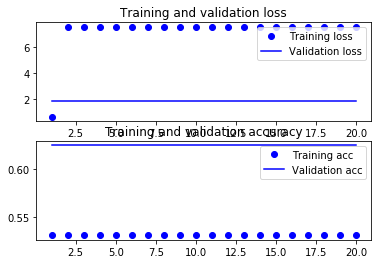

0

In [195]:
mynet.plot_train()

In [180]:
?confusion_matrix

In [196]:
mynet.test()

20/20 [==============================] - 0s 1ms/step


[2.7499778270721436, 0.44999998807907104]

In [197]:
mynet.plot_cm()

ValueError: Found input variables with inconsistent numbers of samples: [20, 1]

In [198]:
mynet.plot_scatter()

ValueError: can only specify one unknown dimension

In [184]:
true = mynet.gene.targets[-8:]

In [182]:
mynet.net.predict(mynet.gene.data[-8:], batch_size=None)

array([[0.50492316],
       [0.5022078 ],
       [0.5014813 ],
       [0.50455445],
       [0.49800202],
       [0.4993081 ],
       [0.5039937 ],
       [0.4958068 ]], dtype=float32)

In [187]:
np.where(mynet.net.predict(mynet.gene.data[-8:], batch_size=None) < 0.5, 0, 1).reshape(1,-1)

array([[1, 1, 1, 1, 0, 0, 1, 0]])

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
pred = np.argmax(mynet.net.predict(mynet.gene.data, batch_size=None), axis=1)
true = np.argmax(mynet.gene.target, axis=1)

In [ ]:
reg = LinearRegression().fit(true.reshape(-1,1), pred.reshape(-1,1))

In [ ]:
plt.scatter(true, pred , marker='o')
plt.title('Linear relationship between true and predicted labels')
plt.xlabel('True label')
plt.ylabel('Predicted label')